# Final model for Question 8

In [2]:
import json
import random
import re
import os
import sys
import collections
import nltk
import tqdm
import itertools
import string
import math
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy as sp
from scipy import sparse
import os.path
import unicodedata

from tqdm import tqdm, trange
from collections import Counter
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer

tokenizer = RegexpTokenizer(r'\w+')

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, LSTM, Multiply

from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.recurrent import LSTM
from keras.layers.merge import concatenate
from keras.layers import Add, Subtract

from keras.callbacks import ModelCheckpoint, EarlyStopping

np.random.seed(7)

Using TensorFlow backend.


In [3]:
def loadGloveModel(gloveFile):
    print("Loading Glove Model")
    f = open(gloveFile,'r')
    model = {}
    for line in f:
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print("Done.",len(model)," words loaded!")
    return model

modelw = loadGloveModel('glove.6B.50d.txt')

Loading Glove Model
Done. 400000  words loaded!


### Code Cell to remove full stops

In [4]:
claims6 = pickle.load(open( "pkl_files/claims6.p", "rb" ))
evid6 = pickle.load(open( "pkl_files/evid6.p", "rb" ))
label6 = pickle.load(open( "pkl_files/label6.p", "rb" ))

claimstest = pickle.load(open( "pkl_files/claimstest.p", "rb" ))
evidtest = pickle.load(open( "pkl_files/evidtest.p", "rb" ))
labeltest = pickle.load(open( "pkl_files/labeltest.p", "rb" ))

claims_temp = []

for claim in claims6:
    last_word = claim[-1]
    temp_claim = claim[:-1]
    temp_claim.append(last_word[:-1])
    claims_temp.append(temp_claim)
    
claims6 = claims_temp

claims_temp = []

for claim in claimstest:
    last_word = claim[-1]
    temp_claim = claim[:-1]
    temp_claim.append(last_word[:-1])
    claims_temp.append(temp_claim)
    
claimstest = claims_temp

### Function for deriving training sentences

In [5]:
def data_maker_train(claims, evids, labels):
    
    #Removing stop words
    stop_words = set(stopwords.words('english'))
    
    stop_claims = []
    stop_evids = []
    for idx, sentence in enumerate(claims):
        filtered_sentence = [w for w in claims[idx] if not w in stop_words]
        filtered_evidence = [w for w in evids[idx] if not w in stop_words]
        stop_claims.append(filtered_sentence)
        stop_evids.append(filtered_evidence)
        
    #Padding the sentences 
    
    #deriving the maximum value
    maxSent = max(len(x) for x in stop_claims)
    maxEvid = max(len(x) for x in stop_evids)
    
    after_pad_sentence = []
    after_pad_evidence = []
    
    for sentence in stop_claims:
        pad_length = maxSent - len(sentence)
        pad_list = ['XXXX']*pad_length
        padded_sentence = sentence + pad_list

        after_pad_sentence.append(padded_sentence)
    
    for sentence in stop_evids:
        pad_length = maxEvid - len(sentence)
        pad_list = ['XXXX']*pad_length
        padded_sentence = sentence + pad_list

        after_pad_evidence.append(padded_sentence)
    
    return(after_pad_sentence, after_pad_evidence, labels, maxSent, maxEvid)

#### Applying function to training data

In [6]:
train_clm, train_evi, train_lab, maxSent, maxEvid = data_maker_train(claims6, evid6, label6)

### Function for deriving test data

In [7]:
def data_maker_test(claims, evids, labels, maxSent, maxEvid):
    
    #Removing stop words
    stop_words = set(stopwords.words('english')) 
    
    stop_claims = []
    stop_evids = []
    for idx, sentence in enumerate(claims):
        filtered_sentence = [w for w in claims[idx] if not w in stop_words]
        filtered_evidence = [w for w in evids[idx] if not w in stop_words]
        stop_claims.append(filtered_sentence)
        stop_evids.append(filtered_evidence)
    
    #Truncating the sentences
    trunc_sent = []
    trunc_evid = []
    for sentence in stop_claims:
        trunc = sentence[:maxSent]
        trunc_sent.append(trunc)
        
    for sentence in stop_evids:
        trunc = sentence[:maxEvid]
        trunc_evid.append(trunc)
    
    #Padding
    after_pad_sentence = []
    for sentence in trunc_sent:
        pad_length = maxSent - len(sentence)
        pad_list = ['XXXX']*pad_length
        padded_sentence = sentence + pad_list

        after_pad_sentence.append(padded_sentence)
    
    after_pad_evidence = []
    for sentence in trunc_evid:
        pad_length = maxEvid - len(sentence)
        pad_list = ['XXXX']*pad_length
        padded_sentence = sentence + pad_list

        after_pad_evidence.append(padded_sentence)

    return(after_pad_sentence, after_pad_evidence, labels)

In [8]:
test_clm, test_evi,test_lab  = data_maker_test(claimstest, evidtest, labeltest, maxSent, maxEvid)

### Balancing the data set to prevent bias in neural network

In [9]:
index_0 = []
index_1 = []

#Creating random sample of indexes from balanced class
for idx, lab in enumerate(train_lab):
    if lab == 0:
        index_0.append(idx)
        
    if lab == 1:
        index_1.append(idx)
        
balance_1 = random.sample(index_1, len(index_0))

balance_idx = balance_1 + index_0

#Creating subset of everything
bal_clm = []
bal_evi = []
bal_lab = []

for idx in balance_idx:
    bal_clm.append(train_clm[idx])
    bal_evi.append(train_evi[idx])
    bal_lab.append(train_lab[idx])

## Shuffling the data

In [10]:
indices = np.arange(len(bal_clm))
np.random.shuffle(indices)

In [11]:
shuf_clm = []
shuf_evi = []
shuf_lab = []

for idx in indices:
    shuf_clm.append(bal_clm[idx])
    shuf_evi.append(bal_evi[idx])
    shuf_lab.append(bal_lab[idx])

## Function to make glove arrays

In [12]:
def array_maker(sent_list):
    
    all_arrays = []
    for sent in sent_list:
        an_array = []   #array for each sentence
        for word in sent:
            try:
                row = modelw[word]
            except:
                row = np.zeros(50)
            an_array.append(row)
        array = np.array(an_array)
        all_arrays.append(an_array)  #List of all arrays
    
    output = np.array(all_arrays)    #Make that into an array
    
    return(output)

In [13]:
clm_train = array_maker(shuf_clm)
evi_train = array_maker(shuf_evi)
lab_train = np.expand_dims(np.array(shuf_lab), axis=1)

clm_test = array_maker(test_clm)
evi_test = array_maker(test_evi)
lab_test = np.expand_dims(np.array(test_lab), axis=1)

### Defining shapes for inputs and outputs

In [14]:
sent_shape = (clm_train.shape[1], clm_train.shape[2])
evid_shape = (evi_train.shape[1], evi_train.shape[2])

### Defining and Fitting Model

In [15]:
# Neural network

# Sentence layer
sent_input = Input(shape=sent_shape, dtype='float32')
sent_lstm = LSTM(32) (sent_input)

# Evidence layer
evid_input = Input(shape=evid_shape, dtype='float32')
evid_lstm = LSTM(32) (evid_input)

# Multi
mult = Multiply() ([sent_lstm, evid_lstm])

# Concat layer
combined = concatenate([sent_lstm, evid_lstm, mult])

# Dense layer
dense_1 = Dense(100, activation='relu') (combined)

# Output layer
model = Model(inputs=[sent_input, evid_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', ])

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 57, 50)       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 131, 50)      0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 32)           10624       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 32)           10624       input_2[0][0]                    
__________________________________________________________________________________________________
multiply_1

In [ ]:
n_epochs = 25
batch_size = 32

#checkpoint = ModelCheckpoint(model_filename, verbose=1, save_best_only=True)
#early_stopping = EarlyStopping(verbose=1)

fit_model = model.fit([clm_train, evi_train], lab_train, 
                    batch_size=batch_size, validation_split=0.2,
                    epochs=n_epochs, verbose=True)

Train on 88331 samples, validate on 22083 samples
Epoch 1/25
88331/88331 [==============================] - 508s 6ms/step - loss: 0.6933 - acc: 0.5001 - val_loss: 0.6931 - val_acc: 0.4985
Epoch 2/25
88331/88331 [==============================] - 505s 6ms/step - loss: 0.6932 - acc: 0.4982 - val_loss: 0.6931 - val_acc: 0.5016
Epoch 3/25
88331/88331 [==============================] - 503s 6ms/step - loss: 0.6932 - acc: 0.5005 - val_loss: 0.6931 - val_acc: 0.4986
Epoch 4/25
88331/88331 [==============================] - 504s 6ms/step - loss: 0.6932 - acc: 0.4971 - val_loss: 0.6931 - val_acc: 0.5016
Epoch 5/25
88331/88331 [==============================] - 505s 6ms/step - loss: 0.6932 - acc: 0.4993 - val_loss: 0.6931 - val_acc: 0.4986
Epoch 6/25
88331/88331 [==============================] - 504s 6ms/step - loss: 0.6931 - acc: 0.4981 - val_loss: 0.6931 - val_acc: 0.5016
Epoch 7/25
88331/88331 [==============================] - 499s 6ms/step - loss: 0.4746 - acc: 0.7626 - val_loss: 0.4989 - 

### Predicting and calculating metrics

In [ ]:
pred = model.predict([clm_test, evi_test], batch_size=batch_size)

In [37]:
y_pred = pred > 0.5

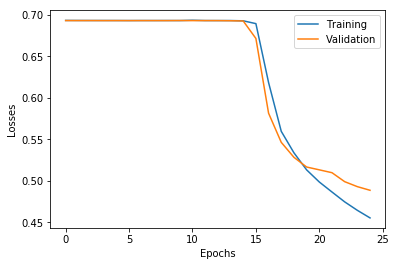

In [35]:
epochs = list(range(0,25))

plt.plot(epochs, fit_model.history['loss'], label='Training')
plt.plot(epochs, fit_model.history['val_loss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()

In [17]:
###Constructing test data
pred = model.predict([clm_array_tst, evi_array_tst], batch_size=batch_size)
y_pred = pred > 0.5
pickle.dump(y_pred, open("pkl_files/final_predictions.p", "wb"))

NameError: name 'clm_array_tst' is not defined

In [41]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, precision_score, recall_score

In [43]:
accuracy_score(lab_test, y_pred)

0.6597357687533251

In [44]:
precision_score(lab_test, y_pred)

0.6492124664879356

In [46]:
recall_score(lab_test, y_pred)

0.6895968674913233

In [48]:
f1_score(lab_test, y_pred)

0.6687955810641696